In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import seaborn as sns
import time
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
kickstarter_data = pd.read_csv('kickstarter_2018.csv')

In [3]:
kickstarter_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
kickstarter_data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [5]:
kickstarter_data['state'] = kickstarter_data['state'].apply(lambda x: 1 if x == 'successful' else 0 )

In [6]:
kickstarter_data['state'].value_counts()

0    244705
1    133956
Name: state, dtype: int64

In [7]:
244705 /(133956+244705)

0.6462376637678556

In [8]:
success_data = kickstarter_data[kickstarter_data['state'] == 1]
fail_data = kickstarter_data[kickstarter_data['state'] == 0]

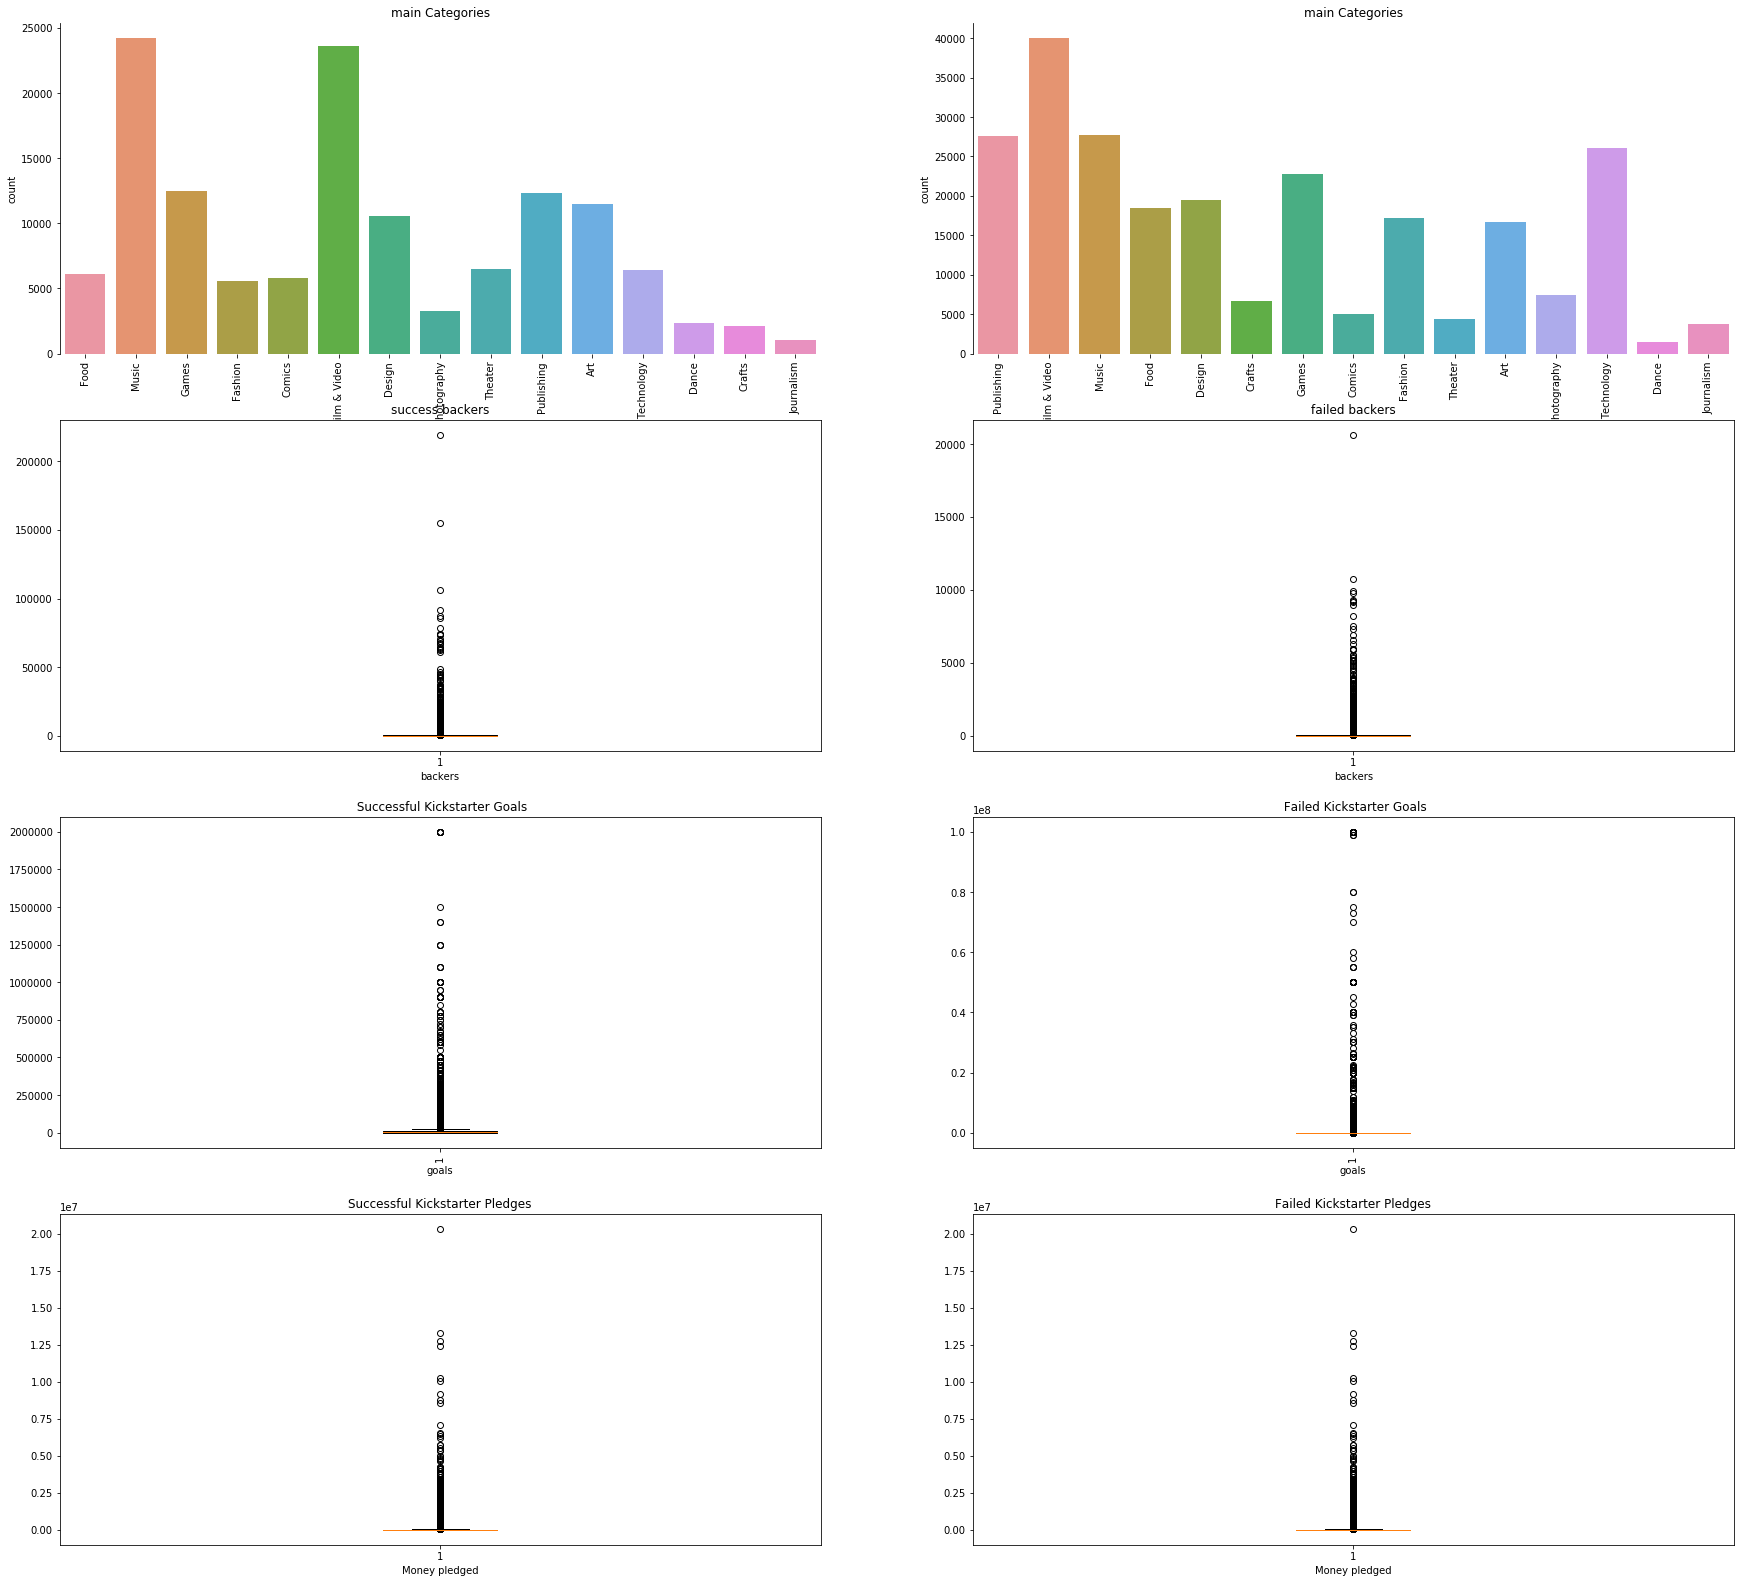

In [9]:
plt.figure(figsize=(30, 28))
plt.subplot(4, 2, 1)
sns.countplot(success_data['main_category'])
plt.title('main Categories')
plt.xlabel("Kickstarter successes in each category")
plt.xticks(rotation = 90)
sns.despine(left=False, bottom=True)

plt.subplot(4, 2, 2)
sns.countplot(fail_data['main_category'])
plt.title('main Categories')
plt.xlabel("Kickstarter nonsuccesses in each category")
plt.xticks(rotation = 90)
sns.despine(left=False, bottom=True)

plt.subplot(4, 2, 3)
plt.boxplot(success_data['backers'])
plt.title('success backers')
plt.xlabel("backers")

plt.subplot(4, 2, 4)
plt.boxplot(fail_data['backers'])
plt.title('failed backers')
plt.xlabel("backers")

plt.subplot(4, 2, 5)
plt.boxplot(success_data['goal'])
plt.title(" Successful Kickstarter Goals")
plt.xlabel("goals")
plt.xticks(rotation = 90)

plt.subplot(4, 2, 6)
plt.boxplot(fail_data['goal'])
plt.title(" Failed Kickstarter Goals")
plt.xlabel("goals")
plt.xticks(rotation = 90)

plt.subplot(4, 2, 7)
plt.boxplot(success_data['pledged'])
plt.title('Successful Kickstarter Pledges')
plt.xlabel("Money pledged")

plt.subplot(4, 2, 8)
plt.boxplot(success_data['pledged'])
plt.title('Failed Kickstarter Pledges')
plt.xlabel("Money pledged")

plt.show()

### Cutting our the outliers

In [10]:
new_ks_data = kickstarter_data[kickstarter_data['pledged']< kickstarter_data['pledged'].quantile(0.85)]

## Selecting features for the model

In [11]:
X = new_ks_data[['main_category', 'country','backers', 'goal', 'usd_goal_real']]
y = new_ks_data["state"]

Converting the categorical values into numerical values so decision tree can run

In [12]:
X = pd.get_dummies(X)

## Decision Tree

In [22]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier()

criterion = ['entropy', 'gini']
max_depth = np.arange(4, 8, 1)
max_features=['sqrt', 'log2']

hyperparameters = dict(
    criterion=criterion,
    max_depth=max_depth,
    max_features = max_features
)
clf = GridSearchCV(decision_tree, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X, y)

# Get results
print('Criterion:', results.best_estimator_.get_params()['criterion'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Max features:', results.best_estimator_.get_params()['max_features'])
print('Best score:', round(results.best_score_, 3))

Criterion: entropy
Max depth: 7
Max features: sqrt
Best score: 0.893


In [24]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth= 7, max_features ='sqrt')
decision_tree.fit(X,y)
decision_tree.feature_importances_

array([  6.60466718e-01,   2.76956373e-01,   2.20286654e-02,
         1.53452234e-04,   9.15784009e-03,   0.00000000e+00,
         5.26644152e-05,   0.00000000e+00,   1.31569502e-07,
         0.00000000e+00,   1.39268934e-04,   3.78824327e-03,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.27917968e-04,   2.48605306e-02,   0.00000000e+00,
         4.58075469e-05,   1.74957184e-03,   2.96920079e-05,
         8.14070558e-06,   5.26304577e-07,   1.54337160e-04,
         1.44669052e-05,   1.15540662e-04,   0.00000000e+00,
         1.08744837e-04,   1.67479445e-06,   6.79118704e-06,
         3.11026524e-05,   0.00000000e+00,   0.00000000e+00,
         1.79773176e-06,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [25]:
cross_val_score(decision_tree, X, y, cv=10)

array([ 0.93618343,  0.78217237,  0.92136088,  0.90855989,  0.75904925,
        0.8748796 ,  0.77877893,  0.90455181,  0.90930558,  0.84933507])

## Forest

In [23]:
forest = ensemble.RandomForestClassifier()
# Specify hyperparameter range
criterion = ['entropy', 'gini']
n_estimators = np.arange(5, 50, 5)
max_depth = np.arange(4, 8, 1)
max_features=['sqrt', 'log2',  'auto']

# Set hyperparameters 
hyperparameters = dict(
    criterion=criterion,
    n_estimators=n_estimators, 
    max_depth=max_depth,
    max_features = max_features
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(forest, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X, y)

# Get results
print('Criterion:', results.best_estimator_.get_params()['criterion'])
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Max features:', results.best_estimator_.get_params()['max_features'])
print('Best score:', round(results.best_score_, 3))

Criterion: gini
n estimators: 30
Max depth: 7
Max features: sqrt
Best score: 0.932


In [26]:
rfc = ensemble.RandomForestClassifier(criterion = 'gini', n_estimators = 30,  max_depth= 7, max_features ='sqrt')
rfc.fit(X, y)
rfc.feature_importances_

array([  5.13237311e-01,   1.48616295e-01,   2.63398013e-01,
         2.62946095e-03,   1.83329129e-03,   1.15762677e-03,
         4.22361439e-03,   1.09654171e-03,   5.32843307e-03,
         1.44256027e-03,   3.39764998e-03,   2.54564150e-03,
         6.84366956e-04,   1.32948732e-02,   2.78165210e-04,
         4.58901163e-04,   1.21282709e-02,   1.10575973e-02,
         2.87993399e-05,   7.39362505e-05,   1.15972029e-05,
         3.02733011e-04,   1.27768581e-05,   1.43429725e-04,
         2.22470378e-05,   1.81589011e-05,   3.30834798e-05,
         1.30815109e-03,   1.14872550e-05,   6.67752320e-06,
         1.26426151e-04,   5.41000946e-10,   5.10606815e-07,
         8.06815443e-04,   6.47387095e-03,   7.58988158e-05,
         2.32085869e-05,   2.58016510e-05,   3.83273208e-05,
         7.77145774e-06,   3.63967738e-03])

In [28]:
start_time = time.time()
cross_val_score(rfc, X, y, cv=10)
print("--- %s seconds ---" % (time.time() - start_time))

--- 35.40298819541931 seconds ---


In [29]:
cross_val_score(rfc, X, y, cv=10)

array([ 0.9308395 ,  0.93087056,  0.92648749,  0.92269691,  0.92667392,
        0.93307441,  0.9326705 ,  0.93211123,  0.93239087,  0.92987199])